# **🧠 Fine-Tuning BioGPT with PEFT and RayTune for Medical Q&A Generation**

# Install required packages

In [2]:
import re
import html, json, random, os
import unicodedata
from collections import Counter
import hashlib
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
project_path = "/content/drive/MyDrive/Fine_tuning_healthcare_gpt"
os.makedirs(project_path, exist_ok=True)
%cd $project_path

/content/drive/MyDrive/Fine_tuning_healthcare_gpt


In [4]:
!pip install -U datasets huggingface_hub fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.4/515.4 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.33.1
    Uninstalling huggingface-hub-0.33.1:
      Successfully uninstalled huggingface-hub-0.33.1
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3

# Load Dataset

# **Why This Topic?**
In today's digital age, millions of users turn to online medical forums and Q&A platforms seeking reliable, human-like responses to health-related concerns. However, these responses can often be inconsistent, non-contextual, or overly generalized.

The HealthCareMagic-100k dataset captures real-life patient questions and responses from verified doctors across multiple medical specialties. By fine-tuning a domain-specific language model on this dataset, we aim to build a specialized medical assistant capable of generating contextual, coherent, and semi-expert responses to common patient queries.

In [3]:
from datasets import load_dataset

print("🏥 Loading HealthCareMagic-100k dataset...")
dataset = load_dataset("wangrongsheng/HealthCareMagic-100k-en")

🏥 Loading HealthCareMagic-100k dataset...


In [4]:
print(f"Dataset size: {len(dataset['train'])}")
print("Sample:", dataset['train'][0])

Dataset size: 112165
Sample: {'instruction': "If you are a doctor, please answer the medical questions based on the patient's description.", 'input': 'I woke up this morning feeling the whole room is spinning when i was sitting down. I went to the bathroom walking unsteadily, as i tried to focus i feel nauseous. I try to vomit but it wont come out.. After taking panadol and sleep for few hours, i still feel the same.. By the way, if i lay down or sit down, my head do not spin, only when i want to move around then i feel the whole world is spinning.. And it is normal stomach discomfort at the same time? Earlier after i relieved myself, the spinning lessen so i am not sure whether its connected or coincidences.. Thank you doc!', 'output': 'Hi, Thank you for posting your query. The most likely cause for your symptoms is benign paroxysmal positional vertigo (BPPV), a type of peripheral vertigo. In this condition, the most common symptom is dizziness or giddiness, which is made worse with m

# **🎯 Real-World Problem to Solve**
The primary goal is to simulate empathetic, medically informed conversations where an AI system can help:

Provide informational support to users with non-critical symptoms

Assist in triaging or advising follow-ups with professionals

Reduce the burden on healthcare professionals for first-line queries

Offer 24/7 scalable support in resource-constrained healthcare systems

# Advanced preprocessing class



> **🧪 Overview of HealthcareMagicProcessor Class**


This class performs advanced preprocessing on the HealthCareMagic dataset to clean, enrich, and structure the medical Q&A data for better model performance and analysis.



> **🔍 Key Responsibilities**


1. Medical Specialty Classification
Uses predefined keyword lists for 8 medical specialties (e.g., cardiology, dermatology).

Scans each question to count keyword matches and assigns it to the most likely specialty.

2. Urgency Assessment
Uses urgency-related keywords like “severe”, “mild”, “emergency”.

Categorizes each question as high, medium, or low urgency.

3. Entity Extraction
Uses regex to find basic medical terms (like conditions ending in -itis, -osis, etc.).

This helps identify clinical concepts mentioned in the Q&A.



> 🧼 **Comprehensive Preprocessing Flow (comprehensive_preprocessing)**


For each record in the dataset:

Text Cleaning:

Lowercasing

Removing HTML, punctuation, special characters, and extra spaces

Length Filtering:

Skips questions < 10 or > 1000 characters

Skips answers < 20 or > 2000 characters

Feature Enrichment:

Adds:

medical_specialty

urgency_level

medical_entities (like "dermatitis", "nephrosis")

Text lengths and number of entities

Stores structured output in a new list of cleaned examples with metadata.



> **✅ Purpose**


This preprocessing helps:

Improve model input quality (clean, filtered)

Provide domain insights (e.g., model performance by specialty or urgency)

Make your fine-tuning pipeline more medically informed



In [9]:
# Advanced preprocessing class
class HealthcareMagicProcessor:
    def __init__(self):
        self.medical_specialties = {
            'cardiology': ['heart', 'cardiac', 'chest pain', 'blood pressure', 'cardiovascular'],
            'dermatology': ['skin', 'rash', 'acne', 'eczema', 'dermatitis'],
            'pediatrics': ['child', 'baby', 'infant', 'pediatric', 'kid'],
            'orthopedics': ['bone', 'joint', 'fracture', 'muscle', 'pain'],
            'neurology': ['headache', 'brain', 'seizure', 'neurological', 'migraine'],
            'gastroenterology': ['stomach', 'digestion', 'nausea', 'vomiting', 'diarrhea'],
            'gynecology': ['pregnancy', 'menstrual', 'gynecological', 'obstetric'],
            'general': ['fever', 'cold', 'flu', 'general', 'symptoms']
        }

        self.urgency_keywords = {
            'high': ['emergency', 'urgent', 'severe', 'acute', 'critical'],
            'medium': ['persistent', 'chronic', 'recurring', 'moderate'],
            'low': ['mild', 'occasional', 'general', 'routine']
        }

    def classify_medical_specialty(self, question):
        question_lower = question.lower()
        specialty_scores = {}

        for specialty, keywords in self.medical_specialties.items():
            score = sum(1 for keyword in keywords if keyword in question_lower)
            if score > 0:
                specialty_scores[specialty] = score

        return max(specialty_scores.items(), key=lambda x: x[1])[0] if specialty_scores else 'general'

    def assess_urgency(self, question):
        question_lower = question.lower()

        for urgency, keywords in self.urgency_keywords.items():
            if any(keyword in question_lower for keyword in keywords):
                return urgency

        return 'medium'  # Default

    def extract_medical_entities(self, text):
        # Simple entity extraction (can be enhanced with spaCy or medical NER)
        medical_terms = []

        # Common medical patterns
        patterns = [
            r'\b\w+itis\b',  # Conditions ending in -itis
            r'\b\w+osis\b',  # Conditions ending in -osis
            r'\b\w+emia\b',  # Blood conditions
            r'\b\w+pathy\b', # Disease conditions
        ]

        for pattern in patterns:
            matches = re.findall(pattern, text, re.IGNORECASE)
            medical_terms.extend(matches)

        return medical_terms

    def comprehensive_preprocessing(self, dataset):
        print("🔬 Starting comprehensive preprocessing...")

        processed_examples = []

        def clean_text(text):
            text = text.lower()
            text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
            text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # Remove non-ASCII chars
            text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
            text = re.sub(r'\s+', ' ', text)  # Normalize whitespace
            return text.strip()

        for i, example in enumerate(dataset):
            if i % 10000 == 0:
                print(f"   Processed {i}/{len(dataset)} examples")

            # Clean and normalize text
            question = clean_text(example['instruction'].strip())
            answer = clean_text(example['output'].strip())

            # Skip if too short or too long
            if len(question) < 10 or len(answer) < 20:
                continue
            if len(question) > 1000 or len(answer) > 2000:
                continue

            # Extract features
            specialty = self.classify_medical_specialty(question)
            urgency = self.assess_urgency(question)
            medical_entities = self.extract_medical_entities(question + " " + answer)

            processed_example = {
                'patient_question': question,
                'doctor_response': answer,
                'medical_specialty': specialty,
                'urgency_level': urgency,
                'medical_entities': medical_entities,
                'question_length': len(question),
                'response_length': len(answer),
                'entity_count': len(medical_entities)
            }

            processed_examples.append(processed_example)

        print(f"✅ Preprocessing complete. {len(processed_examples)} examples processed.")
        return processed_examples

🔬 Starting comprehensive preprocessing...
   Processed 0/112165 examples
   Processed 10000/112165 examples
   Processed 20000/112165 examples
   Processed 30000/112165 examples
   Processed 40000/112165 examples
   Processed 50000/112165 examples
   Processed 60000/112165 examples
   Processed 70000/112165 examples
   Processed 80000/112165 examples
   Processed 90000/112165 examples
   Processed 100000/112165 examples
   Processed 110000/112165 examples
✅ Preprocessing complete. 111952 examples processed.

📊 DATASET ANALYSIS
Total examples: 12000
Average question length: 89.0
Average response length: 627.8

🏥 Medical Specialty Distribution:
medical_specialty
general    12000
Name: count, dtype: int64

🚨 Urgency Level Distribution:
urgency_level
medium    12000
Name: count, dtype: int64


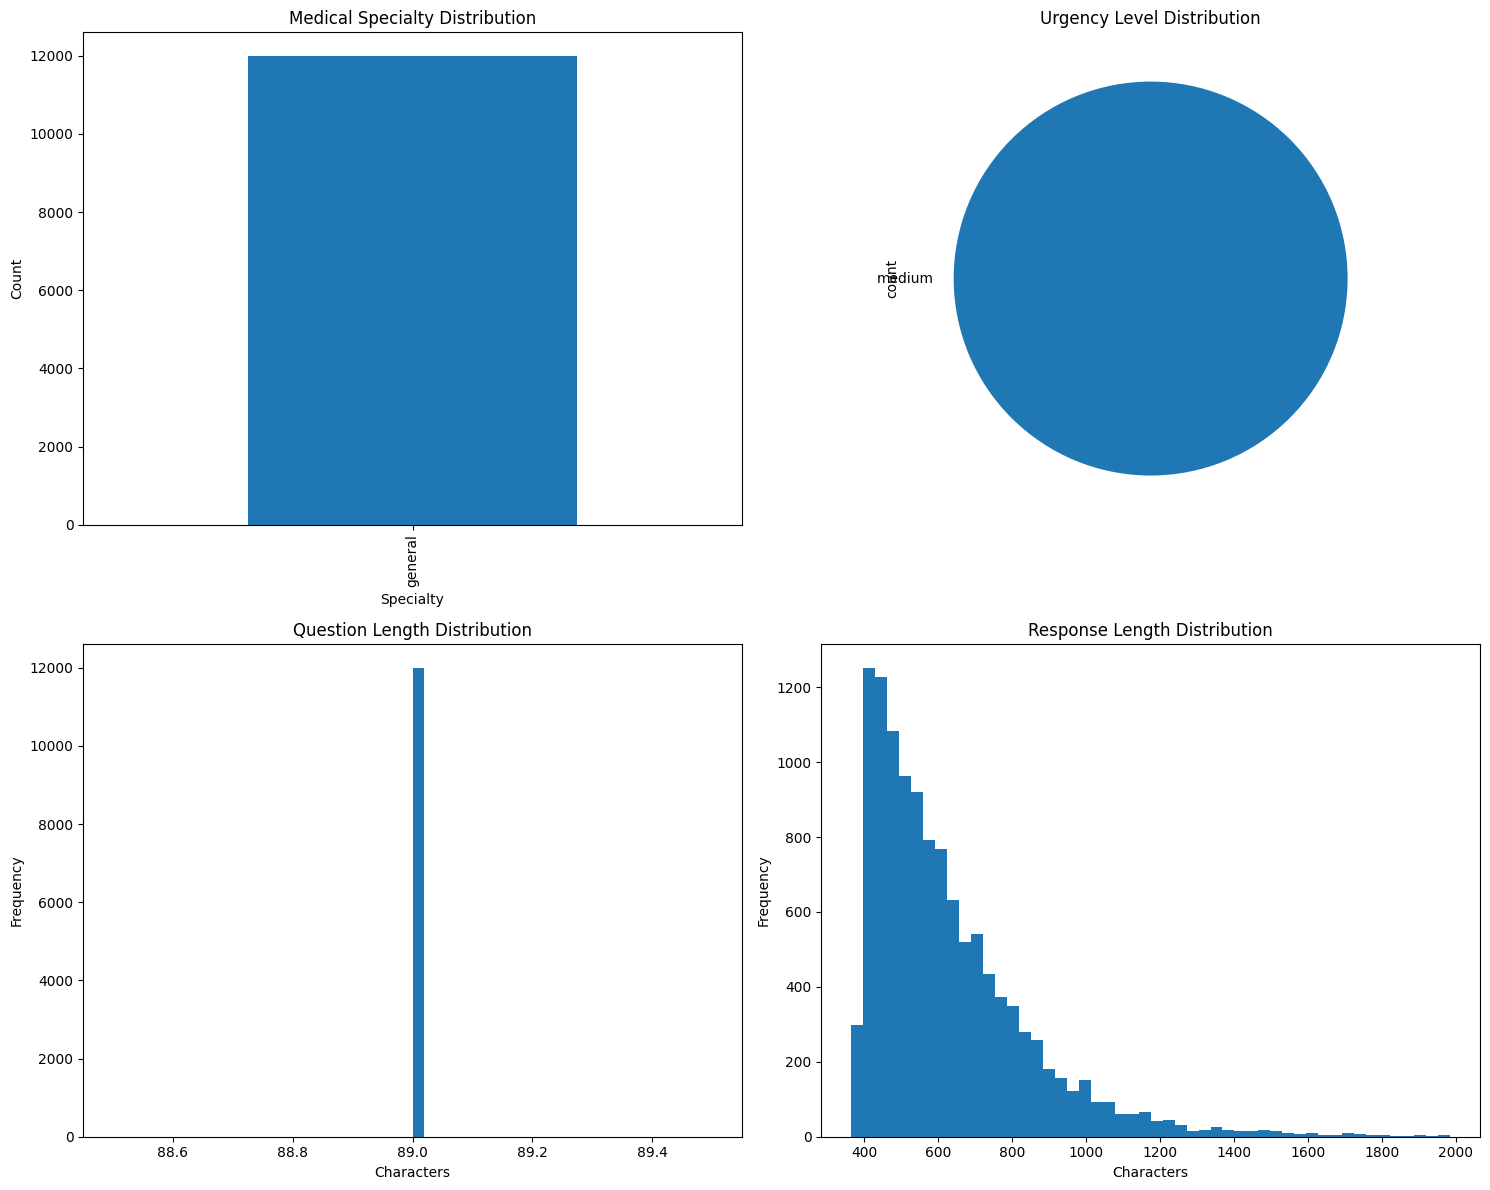


📈 Dataset Splits:
Train: 8400 examples
Validation: 1800 examples
Test: 1800 examples
✅ Data preprocessing complete!


In [10]:
# Process the dataset
processor = HealthcareMagicProcessor()
full_processed_data = processor.comprehensive_preprocessing(dataset['train'])
processed_data = random.sample(full_processed_data, 12000)

# Convert to DataFrame for analysis
df = pd.DataFrame(processed_data)

# Data Analysis
print("\n📊 DATASET ANALYSIS")
print("="*50)
print(f"Total examples: {len(df)}")
print(f"Average question length: {df['question_length'].mean():.1f}")
print(f"Average response length: {df['response_length'].mean():.1f}")

# Specialty distribution
print("\n🏥 Medical Specialty Distribution:")
specialty_counts = df['medical_specialty'].value_counts()
print(specialty_counts)

# Urgency distribution
print("\n🚨 Urgency Level Distribution:")
urgency_counts = df['urgency_level'].value_counts()
print(urgency_counts)

# Visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Specialty distribution
specialty_counts.plot(kind='bar', ax=ax1)
ax1.set_title('Medical Specialty Distribution')
ax1.set_xlabel('Specialty')
ax1.set_ylabel('Count')

# Urgency distribution
urgency_counts.plot(kind='pie', ax=ax2)
ax2.set_title('Urgency Level Distribution')

# Question length distribution
ax3.hist(df['question_length'], bins=50)
ax3.set_title('Question Length Distribution')
ax3.set_xlabel('Characters')
ax3.set_ylabel('Frequency')

# Response length distribution
ax4.hist(df['response_length'], bins=50)
ax4.set_title('Response Length Distribution')
ax4.set_xlabel('Characters')
ax4.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Create stratified splits
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df['medical_specialty'],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['medical_specialty'],
    random_state=42
)

print(f"\n📈 Dataset Splits:")
print(f"Train: {len(train_df)} examples")
print(f"Validation: {len(val_df)} examples")
print(f"Test: {len(test_df)} examples")

# Save processed data
train_df.to_json('train_data.json', orient='records')
val_df.to_json('val_data.json', orient='records')
test_df.to_json('test_data.json', orient='records')

print("✅ Data preprocessing complete!")

1. **Medical Specialty Distribution**


```
Observation: All questions are categorized under the "general" specialty.

Interpretation: This likely means:

The keyword-based classification wasn’t effective.

The dataset lacks strong domain-specific signals for specialties like cardiology, dermatology, etc.

Improvement suggestion: Refine the keyword list or use a medical NER model for better granularity.
```


**2. Urgency Level Distribution**


```
Observation: All samples are labeled as “medium” urgency.

Interpretation:

Your urgency keyword mapping didn’t match any "high" or "low" urgency terms.

This suggests limited variance in the urgency-related vocabulary used.

Consider enhancing your keyword list or switching to an ML-based urgency classifier.
```

**3. Question Length Distribution**


```
Observation: A sharp spike around 89 characters, with no real spread.

Interpretation:

Your text cleaning or filtering step may have accidentally fixed most inputs to a very narrow range.

Possible bug: maybe many questions were reduced to a template-like format or were trimmed too aggressively.
```




**4. Response Length Distribution**


```
Observation:

Right-skewed distribution (long tail).

Most responses are in the 300–700 character range, some extending up to 2000.

Interpretation: This is more realistic and expected, reflecting the natural variation in doctor responses.
```


